# [synchronized的四种用法](https://www.cnblogs.com/lukelook/p/9946065.html)

## 一 修饰方法 

Synchronized修饰一个方法很简单，就是在方法的前面加synchronized，synchronized修饰方法和修饰一个代码块类似，只是作用范围不一样，**修饰代码块是大括号括起来的范围，而修饰方法范围是整个函数。**

例如：

### 方法一

In [ ]:
public class Test{
    public synchronized void method(){
       // todo
    }
}

### 方法二

In [ ]:
public class Test{
    public void method(){
       synchronized(this) {
          // todo
       }
    }
}

写法一修饰的是一个方法，写法二修饰的是一个代码块，但写法一与写法二是等价的，都是锁定了整个方法时的内容。

synchronized关键字不能继承。 

虽然可以使用synchronized来定义方法，但synchronized并不属于方法定义的一部分，因此，synchronized关键字不能被继承。如果在父类中的某个方法使用了synchronized关键字，而在子类中覆盖了这个方法，在子类中的这个方法默认情况下并不是同步的，而必须显式地在子类的这个方法中加上synchronized关键字才可以。当然，还可以在子类方法中调用父类中相应的方法，这样虽然子类中的方法不是同步的，但子类调用了父类的同步方法，因此，子类的方法也就相当于同步了。这两种方式的例子代码如下： 

在子类方法中加上synchronized关键字

In [ ]:
class Parent {
   public synchronized void method() { }
}
class Child extends Parent {
   public synchronized void method() { }
}

在子类方法中调用父类的同步方法

In [ ]:
class Parent {
   public synchronized void method() {   }
}
class Child extends Parent {
   public void method() { super.method();   }
} 

### 注意点：接口&构造方法
1. 在定义接口方法时不能使用synchronized关键字。
2. 构造方法不能使用synchronized关键字，但可以使用synchronized代码块来进行同步

## 修饰一个代码块
### 对象中的synchronized(this)
一个线程访问一个对象中的synchronized(this)同步代码块时，其他试图访问该对象的线程将被阻塞

注意下面两个程序的区别

In [ ]:
class SyncThread implements Runnable {
       private static int count;
 
       public SyncThread() {
          count = 0;
       }
 
       public  void run() {
          synchronized(this) {
             for (int i = 0; i < 5; i++) {
                try {
                   System.out.println(Thread.currentThread().getName() + ":" + (count++));
                   Thread.sleep(1);
                } catch (InterruptedException e) {
                   e.printStackTrace();
                }
             }
          }
       }
 
       public int getCount() {
          return count;
       }
}
 
class Test{
    public static void main(){
        //test01
        //SyncThread s1 = new SyncThread();
        //SyncThread s2 = new SyncThread();
        //Thread t1 = new Thread(s1);
        //Thread t2 = new Thread(s2);

        //test02        
        SyncThread s = new SyncThread();
        Thread t1 = new Thread(s);
        Thread t2 = new Thread(s);

        t1.start();
        t2.start();
    }
}

In [ ]:
Test.main();
//run on notebook is error

test01的运行结果
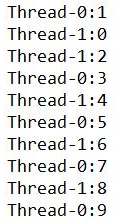
test02的运行结果
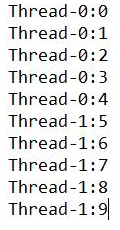
当两个并发线程(thread1和thread2)访问同一个对象(syncThread)中的synchronized代码块时，在同一时刻只能有一个线程得到执行，另一个线程受阻塞，必须等待当前线程执行完这个代码块以后才能执行该代码块。Thread1和thread2是互斥的，因为在执行synchronized代码块时会锁定当前的对象，只有执行完该代码块才能释放该对象锁，下一个线程才能执行并锁定该对象

为什么上面的例子中thread1和thread2同时在执行。这是因为synchronized只锁定对象，每个对象只有一个锁（lock）与之相关联。

In [4]:
class Counter implements Runnable{
   private int count;
 
   public Counter() {
      count = 0;
   }
 
   public void countAdd() {
      synchronized(this) {
         for (int i = 0; i < 5; i ++) {
            try {
               System.out.println(Thread.currentThread().getName() + ":" + (count++));
               Thread.sleep(100);
            } catch (InterruptedException e) {
               e.printStackTrace();
            }
         }
      }
   }
 
   //非synchronized代码块，未对count进行读写操作，所以可以不用synchronized
   public void printCount() {
      for (int i = 0; i < 5; i ++) {
         try {
            System.out.println(Thread.currentThread().getName() + " count:" + count);
            Thread.sleep(100);
         } catch (InterruptedException e) {
            e.printStackTrace();
         }
      }
   }
 
   public void run() {
      String threadName = Thread.currentThread().getName();
      if (threadName.equals("A")) {
         countAdd();
      } else if (threadName.equals("B")) {
         printCount();
      }
   }
}
 
public class Demo00{
    public static void main(){
        Counter counter = new Counter();
        Thread thread1 = new Thread(counter, "A");
        Thread thread2 = new Thread(counter, "B");
        thread1.start();
        thread2.start();
    }
}

In [6]:
Demo00.main();

B count:1

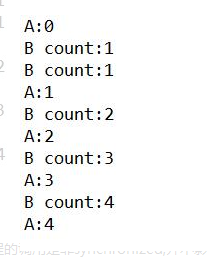
可以看见B线程的调用是非synchronized,并不影响A线程对synchronized部分的调用。从上面的结果中可以看出一个线程访问一个对象的synchronized代码块时，别的线程可以访问该对象的非synchronized代码块而不受阻塞。

### 指定要给某个对象加锁

In [11]:
/**
 * 银行账户类
 */
class Account {
   String name;
   float amount;
 
   public Account(String name, float amount) {
      this.name = name;
      this.amount = amount;
   }
   //存钱
   public  void deposit(float amt) {
      amount += amt;
      try {
         Thread.sleep(100);
      } catch (InterruptedException e) {
         e.printStackTrace();
      }
   }
   //取钱
   public  void withdraw(float amt) {
      amount -= amt;
      try {
         Thread.sleep(100);
      } catch (InterruptedException e) {
         e.printStackTrace();
      }
   }
 
   public float getBalance() {
      return amount;
   }
}
 
/**
 * 账户操作类
 */
class AccountOperator implements Runnable{
   private Account account;
   public AccountOperator(Account account) {
      this.account = account;
   }
 
   public void run() {
      synchronized (account) {
         account.deposit(500);
         account.withdraw(500);
         System.out.println(Thread.currentThread().getName() + ":" + account.getBalance());
      }
   }
}
 
public class Demo00{
    
    //public static final Object signal = new Object(); // 线程间通信变量
    //将account改为Demo00.signal也能实现线程同步
    public static void main(){
        Account account = new Account("zhang san", 10000.0f);
        AccountOperator accountOperator = new AccountOperator(account);
 
        final int THREAD_NUM = 5;
        Thread threads[] = new Thread[THREAD_NUM];
        for (int i = 0; i < THREAD_NUM; i ++) {
           threads[i] = new Thread(accountOperator, "Thread" + i);
           threads[i].start();
        }
    }
}

In [13]:
Demo00.main();

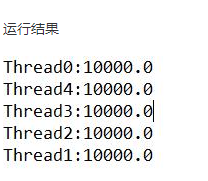
在AccountOperator 类中的run方法里，我们用synchronized 给account对象加了锁。这时，当一个线程访问account对象时，其他试图访问account对象的线程将会阻塞，直到该线程访问account对象结束。也就是说谁拿到那个锁谁就可以运行它所控制的那段代码。 
当有一个明确的对象作为锁时，就可以用类似下面这样的方式写程序。

In [19]:
public class Test{
    public void method3(Object obj){
       //obj 锁定的对象
       synchronized(obj){
          // todo
       }
    }
}

当没有明确的对象作为锁，只是想让一段代码同步时，可以创建一个特殊的对象来充当锁：

In [21]:
class Test implements Runnable{
   private byte[] lock = new byte[0];  // 特殊的instance变量
   public void method(){
      synchronized(lock) {
         // todo 同步代码块
      }
   }
 
   public void run() {
 
   }
}

本例中去掉注释中的signal可以看到同样的运行结果

## 修饰一个静态的方法

Synchronized也可修饰一个静态方法，用法如下：

In [24]:
public class Test{
    public synchronized static void method() {
       // todo
    }
}

静态方法是属于类的而不属于对象的。同样的，synchronized修饰的静态方法锁定的是这个类的所有对象。

In [26]:
/**
 * 同步线程
 */
class SyncThread implements Runnable {
   private static int count;
 
   public SyncThread() {
      count = 0;
   }
 
   public synchronized static void method() {
      for (int i = 0; i < 5; i ++) {
         try {
            System.out.println(Thread.currentThread().getName() + ":" + (count++));
            Thread.sleep(100);
         } catch (InterruptedException e) {
            e.printStackTrace();
         }
      }
   }
 
   public synchronized void run() {
      method();
   }
}
 
public class Demo00{
    
    public static void main(){
        SyncThread syncThread1 = new SyncThread();
        SyncThread syncThread2 = new SyncThread();
        Thread thread1 = new Thread(syncThread1, "SyncThread1");
        Thread thread2 = new Thread(syncThread2, "SyncThread2");
        thread1.start();
        thread2.start();
    }
}

In [27]:
Demo00.main();

SyncThread1:0


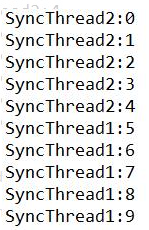
syncThread1和syncThread2是SyncThread的两个对象，但在thread1和thread2并发执行时却保持了线程同步。这是因为run中调用了静态方法method，而静态方法是属于类的，所以syncThread1和syncThread2相当于用了同一把锁。

## 修饰一个类
Synchronized还可作用于一个类，用法如下：

In [28]:
class ClassName {
   public void method() {
      synchronized(ClassName.class) {
         // todo
      }
   }
}

In [29]:
/**
 * 同步线程
 */
class SyncThread implements Runnable {
   private static int count;
 
   public SyncThread() {
      count = 0;
   }
 
   public static void method() {
      synchronized(SyncThread.class) {
         for (int i = 0; i < 5; i ++) {
            try {
               System.out.println(Thread.currentThread().getName() + ":" + (count++));
               Thread.sleep(100);
            } catch (InterruptedException e) {
               e.printStackTrace();
            }
         }
      }
   }
 
   public synchronized void run() {
      method();
   }
}

本例的的给class加锁和上例的给静态方法加锁是一样的，所有对象公用一把锁

## 总结

1. 无论synchronized关键字加在方法上还是对象上，如果它作用的对象是非静态的，则它取得的锁是对象；如果synchronized作用的对象是一个静态方法或一个类，则它取得的锁是对类，该类所有的对象同一把锁。 
2. 每个对象只有一个锁（lock）与之相关联，谁拿到这个锁谁就可以运行它所控制的那段代码。 
3. 实现同步是要很大的系统开销作为代价的，甚至可能造成死锁，所以尽量避免无谓的同步控制。